In [2]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [6]:
df.columns =['Sales']

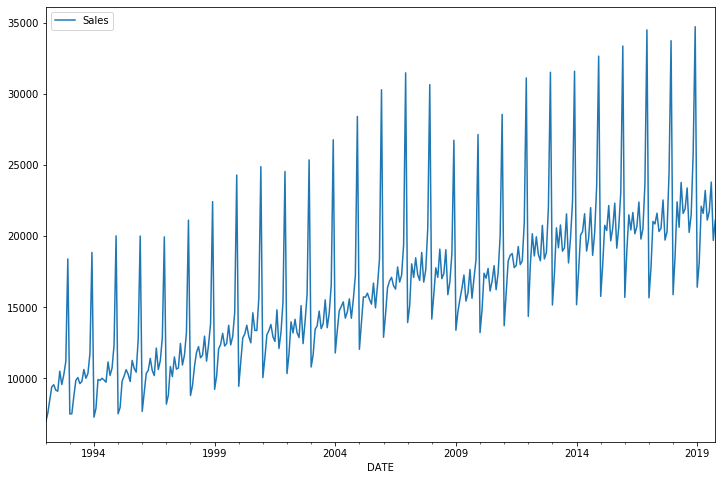

In [7]:
df.plot(figsize=(12,8))

In [8]:
len(df)

334

In [9]:
test_size = 18
test_ind = len(df)-test_size

In [10]:
train = df.iloc[: test_ind]
test = df.iloc[test_ind:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
scaled_train = scaler.transform(train)

In [18]:
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
len(test) 

18

In [22]:
length=12
# note to self: length should not be equal, but it should be less than length test set.
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [23]:
from tensorflow.keras.models import Sequential

In [24]:
from tensorflow.keras.layers import Dense, LSTM

In [25]:
n_features = 1

In [29]:
model= Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [33]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [35]:
model.fit_generator(generator, epochs=20,
                   validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 130s 427ms/step - loss: 0.0206 - val_loss: 0.0307
Epoch 2/20
304/304 [==============================] - 135s 443ms/step - loss: 0.0183 - val_loss: 0.0366
Epoch 3/20
304/304 [==============================] - 134s 441ms/step - loss: 0.0103 - val_loss: 0.0043
Epoch 4/20
304/304 [==============================] - 136s 446ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 5/20
304/304 [==============================] - 137s 451ms/step - loss: 0.0027 - val_loss: 0.0091
Epoch 6/20
304/304 [==============================] - 135s 445ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/20
304/304 [==============================] - 136s 448ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/20
304/304 [==============================] - 135s 445ms/step - loss: 0.0013 - val_loss: 7.1509e-04
Epoch 9/20
304/304 [==============================] - 137s 451ms/step - loss: 0.0020 - val_loss: 4.9935e-04
Epoch 10/20
304/304 [==============================] - 1

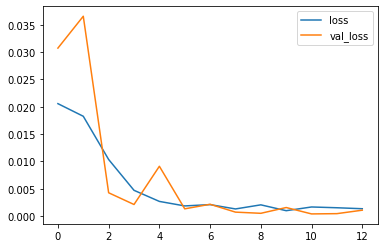

In [37]:
losses= pd.DataFrame(model.history.history)
losses.plot()

In [38]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [40]:
true_predictions =scaler.inverse_transform(test_predictions)

In [41]:
test['Predictions'] = true_predictions

/Users/fredyyudiawan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


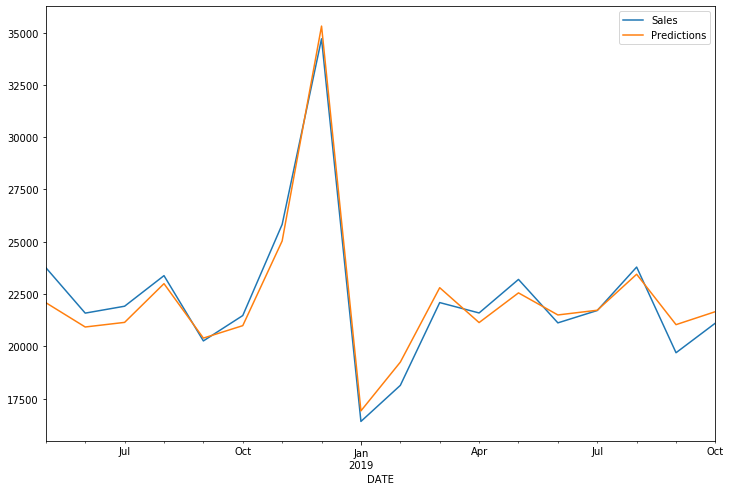

In [44]:
test.plot(figsize=(12,8))